# Import Spark

In [1]:
!pip install wget
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar xf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession 

# Read and check data

In [0]:
import wget
link_to_data = 'https://github.com/tulip-lab/sit742/raw/master/Assessment/2019/data/bank.csv'
DataSet = wget.download(link_to_data)

In [4]:
!ls

'bank (1).csv'		     spark-2.4.0-bin-hadoop2.7.tgz
'bank (2).csv'		     spark-2.4.0-bin-hadoop2.7.tgz.1
'bank (3).csv'		     spark-2.4.0-bin-hadoop2.7.tgz.2
 bank.csv		     spark-2.4.0-bin-hadoop2.7.tgz.3
 sample_data		     spark-warehouse
 spark-2.4.0-bin-hadoop2.7


In [5]:
# Importing 'bank.csv' as Spark dataframe
spark = SparkSession.builder.appName('ml-bank').getOrCreate()
df = spark.read.csv('bank.csv', header = True, inferSchema = True) 
df.printSchema() 
df.show(10)

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)

+---+----------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+-------

In [6]:
# Checking data distribution
df.describe().show() 

+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|summary|               age|    job| marital|education|default|           balance|housing| loan| contact|               day|month|          duration|          campaign|             pdays|          previous|poutcome|deposit|
+-------+------------------+-------+--------+---------+-------+------------------+-------+-----+--------+------------------+-----+------------------+------------------+------------------+------------------+--------+-------+
|  count|             11162|  11162|   11162|    11162|  11162|             11162|  11162|11162|   11162|             11162|11162|             11162|             11162|             11162|             11162|   11162|  11162|
|   mean|41.231947679627304|   null|    null|     null|   null|1528.5385235620856|   null| null|    null

# Select features for df2



In [7]:
df2 = df.select('age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'campaign', 'pdays', 'previous', 'poutcome', 'deposit')
df2.show(10)

+---+----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|       job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+----------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 59|    admin.| married|secondary|     no|   2343|    yes|  no|       1|   -1|       0| unknown|    yes|
| 56|    admin.| married|secondary|     no|     45|     no|  no|       1|   -1|       0| unknown|    yes|
| 41|technician| married|secondary|     no|   1270|    yes|  no|       1|   -1|       0| unknown|    yes|
| 55|  services| married|secondary|     no|   2476|    yes|  no|       1|   -1|       0| unknown|    yes|
| 54|    admin.| married| tertiary|     no|    184|     no|  no|       2|   -1|       0| unknown|    yes|
| 42|management|  single| tertiary|     no|      0|    yes| yes|       2|   -1|       0| unknown|    yes|
| 56|management| married| tertiary|     no|   

In [0]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
sparkc = SparkContext.getOrCreate()
sqlContext = SQLContext(sparkc)

In [0]:
#Removing invalid rows using spark.sql 
from pyspark.sql import SparkSession
df2.registerTempTable("bank")

In [10]:
#Filtering rows from attributes which has 'unknown' entry
filter = sqlContext.sql("SELECT * FROM bank WHERE job!= 'unknown' AND education!= 'unknown' AND poutcome!='unknown' AND poutcome!='other'")
filter.show(10)

+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
| 37|  technician| married|secondary|     no|   5115|    yes|  no|       2|  171|       4| failure|    yes|
| 45|entrepreneur| married|secondary|     no|    781|     no| yes|       2|  126|       2| failure|    yes|
| 46|  unemployed|divorced|s

In [0]:
#Converting categorical features to metric features using One hot encoding
import numpy as np
from pyspark.mllib.linalg import SparseVector
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoderEstimator, OneHotEncoderModel
from pyspark.ml.feature import VectorAssembler

In [0]:
categor_Columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'poutcome']
stages = []
cols = filter.columns

In [0]:
for categoricalCol in categor_Columns:
    stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]
String_label = StringIndexer(inputCol = 'deposit', outputCol = 'labels')
stages += [String_label]
Num_Columns = ['age', 'balance', 'campaign', 'pdays', 'previous']
Input_assembler = [c + "classVec" for c in categor_Columns] + Num_Columns
assembler = VectorAssembler(inputCols=Input_assembler, outputCol="features")
stages += [assembler]

In [14]:
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(filter)
filter = pipelineModel.transform(filter)
selectedCols = ['labels', 'features'] + cols
filter = filter.select(selectedCols)
filter.printSchema()

root
 |-- labels: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



In [15]:
filter.show(10)

+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|
|   0.0|(23,[4,10,13,14,1...| 53|     retired| married| tertiary|     no|   2269|     no|  no|       2|  150|       1| success|    yes|
|   0.0|(23,[1,10,12,14,1...| 37|  technician| m

## Normalisation

In [16]:
#Applying Min-Max normalisation on each attribute using MinMaxScaler from pyspark.ml.feature
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.linalg import Vectors
scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")

# Computing summary statistics and generating MinMaxScalerModel
Scaler_model = scaler.fit(filter)

# rescale each feature to range [min, max].
Scaled_Data = Scaler_model.transform(filter)
print("Features scaled to range: [%f, %f]" % (scaler.getMin(), scaler.getMax()))
Scaled_Data.show(10)

Features scaled to range: [0.000000, 1.000000]
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|      scaledFeatures|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|[0.0,0.0,1.0,0.0,...|
|   0.0|(23

# Unsupervised learning

##  K-means

In [17]:
# performing Kmeans on df2  
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

kmeans = KMeans(k=2, seed=1)  # clusters = 2
model = kmeans.fit(Scaled_Data.select('features'))

transformed = model.transform(Scaled_Data)
transformed.show(10)   

+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+----------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|      scaledFeatures|prediction|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+----------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|         1|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|         1|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| failure|    yes|[0.0,0.0,1.0,0.0,...|    

In [18]:
#Clustering with cluster = 2
import numpy as np

kmeans = KMeans(k=2, seed=1, featuresCol="features", predictionCol="Cluster")
model = kmeans.fit(Scaled_Data.select('features'))

model = kmeans.fit(Scaled_Data)
cluster = model.transform(transformed)
cluster.show(10)

+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+----------+-------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|      scaledFeatures|prediction|Cluster|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+----------+-------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|         1|      1|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|         1|      1|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170|       3| f

In [19]:
#printing centers for clusters
Center = model.clusterCenters()
print("Cluster Centers: ")
for center in Center:
    print(center)

Cluster Centers: 
[3.24561404e-01 1.92982456e-01 7.89473684e-02 6.14035088e-02
 1.22807018e-01 4.38596491e-02 3.50877193e-02 7.89473684e-02
 6.14035088e-02 0.00000000e+00 5.87719298e-01 3.59649123e-01
 3.15789474e-01 5.43859649e-01 1.00000000e+00 6.31578947e-01
 9.91228070e-01 4.73684211e-01 4.36754386e+01 1.17268860e+04
 2.00000000e+00 1.81456140e+02 2.94736842e+00]
[2.50604741e-01 1.60619255e-01 1.45621674e-01 1.27721335e-01
 8.80503145e-02 7.25689405e-02 4.35413643e-02 3.77358491e-02
 3.24141268e-02 2.08030963e-02 5.64586357e-01 3.39138849e-01
 5.10401548e-01 3.90420900e-01 9.96613449e-01 5.44267054e-01
 8.97435897e-01 5.42815675e-01 4.17426222e+01 1.19230866e+03
 1.81132075e+00 2.04038220e+02 3.09966134e+00]


## PCA

In [20]:
#Generating a scatter plot to investigate the data distribution using the first two PCA components.
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.clustering import GaussianMixture

Pca = PCA(k=4, inputCol="scaledFeatures", outputCol="Pca")
Pca_model = Pca.fit(Scaled_Data)
transformed = Pca_model.transform(Scaled_Data)

features = transformed.select('Pca').rdd.map(lambda x: np.array(x))
transformed.show(10)

+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|      scaledFeatures|                 Pca|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|[0.96364248505160...|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|[0.83734101836268...|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|     no|    899|    yes|  no|       1|  170| 

Text(0.5, 1.0, 'Scatter plot')

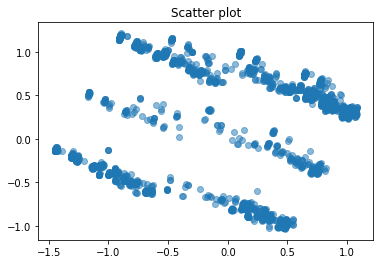

In [21]:
import matplotlib.pyplot as plt
Pca_plot = np.array(features.collect()).squeeze()
plt.scatter(Pca_plot[:,0],Pca_plot[:,1],alpha = 0.5)
plt.title('Scatter plot')

In [41]:
y = Scaled_Data['labels']

Components = 2
Pca = PCA(
    k = Components, 
    inputCol = 'scaledFeatures', 
    outputCol = 'PcaFeatures'
).fit(Scaled_Data)

df_pca = Pca.transform(Scaled_Data)
print('Explained Variance: ', Pca.explainedVariance.toArray())
df_pca.show(10)

Explained Variance:  [0.24018136 0.17260419]
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|labels|            features|age|         job| marital|education|default|balance|housing|loan|campaign|pdays|previous|poutcome|deposit|      scaledFeatures|         PcaFeatures|
+------+--------------------+---+------------+--------+---------+-------+-------+-------+----+--------+-----+--------+--------+-------+--------------------+--------------------+
|   0.0|(23,[5,10,12,14,1...| 33|    services| married|secondary|     no|   3444|    yes|  no|       1|   91|       4| failure|    yes|[0.0,0.0,0.0,0.0,...|[0.96364248505160...|
|   0.0|(23,[1,10,12,14,1...| 56|  technician| married|secondary|     no|    589|    yes|  no|       1|  147|       2| success|    yes|[0.0,1.0,0.0,0.0,...|[0.83734101836268...|
|   0.0|(23,[2,10,13,14,1...| 34|      admin.| married| tertiary|

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import decomposition
%matplotlib inline

X_pca = df_pca.rdd.map(lambda row: row.PcaFeatures).collect()
X_pca = np.array(X_pca)

In [0]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['font.size'] = 12



def plot_pca(X_pca, y):
    """a scatter plot of the 2-dimensional iris data"""
    markers = 'x', 'o'
    colors = list(plt.rcParams['axes.prop_cycle'])
    target = np.unique(y)
    for idx, (t, m) in enumerate(zip(target, markers)):
        subset = X_pca[y == t]
        plt.scatter(subset[:, 0], subset[:, 1],
                    c = colors[idx]['color'], label = t, marker = m)

    plt.xlabel('PC 1')
    plt.ylabel('PC 2')
    plt.legend(loc = 'lower left')
    plt.tight_layout()
    plt.show()

In [0]:
gmm = GaussianMixture.train(features, k=2)
predict = gmm.predict(features).collect()
labels = scaledData.select('labels').rdd.map(lambda r: r[0]).collect()
np.corrcoef(predict, labels)

In [0]:
xs = np.array(features.collect()).squeeze()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].scatter(xs[:, 0], xs[:,1], c=predict)
axes[0].set_title('Predicted')
axes[1].scatter(xs[:, 0], xs[:,1], c=labels)
axes[1].set_title('Labels')

# Supervised learning

##  Logistic Regression Model

In [26]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train, test = Scaled_Data.randomSplit([0.7, 0.3], seed = 742)
print("Training Data Count: " + str(train.count()))
print("Test Data Count: " + str(test.count()))

log_reg = LogisticRegression(featuresCol = 'scaledFeatures', labelCol = 'labels', maxIter=10)
Log_reg_model = log_reg.fit(train)

Training Data Count: 1535
Test Data Count: 646


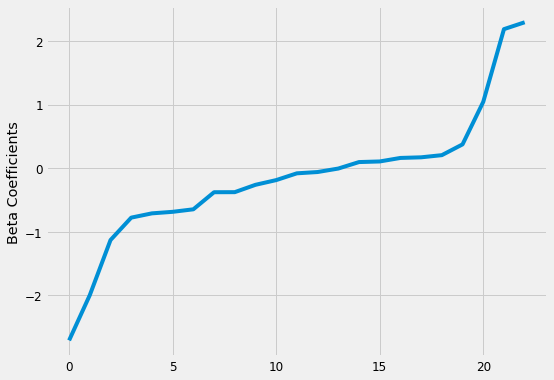

In [27]:
#Examining coefficients
import matplotlib.pyplot as plt
import numpy as np

Beta = np.sort(Log_reg_model.coefficients)

plt.plot(Beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [0]:
Training_summary = Log_reg_model.summary

In [29]:
Prediction = Log_reg_model.transform(test)
Prediction.select('age', 'job', 'labels', 'rawPrediction', 'prediction', 'probability').show(10)

+---+----------+------+--------------------+----------+--------------------+
|age|       job|labels|       rawPrediction|prediction|         probability|
+---+----------+------+--------------------+----------+--------------------+
| 29|management|   0.0|[0.20581400401594...|       0.0|[0.55127263878287...|
| 52|management|   0.0|[0.31464400007368...|       0.0|[0.57801840224098...|
| 48|management|   0.0|[2.75843511433406...|       0.0|[0.94038796941248...|
| 33|management|   0.0|[-0.0148119354374...|       1.0|[0.49629708384002...|
| 48|management|   0.0|[-0.4210045818029...|       1.0|[0.39627638754076...|
| 49|management|   0.0|[-0.4097384848671...|       1.0|[0.39897482923205...|
| 31|management|   0.0|[0.97185596686588...|       0.0|[0.72548927674934...|
| 32|management|   0.0|[0.99783494329516...|       0.0|[0.73063268975904...|
| 33|management|   0.0|[0.66785620582997...|       0.0|[0.66102296174890...|
| 34|management|   0.0|[1.24372136375727...|       0.0|[0.77621110717051...|

In [30]:
# Computing test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(Prediction)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.263158


## 5.2 Decision tree

In [31]:
#Decision tree
train, test = Scaled_Data.randomSplit([0.7, 0.3], seed = 742)
print("Training Data Count: " + str(train.count()))
print("Test Data Count: " + str(test.count()))

from pyspark.ml.classification import DecisionTreeClassifier 
Decision_tree = DecisionTreeClassifier(featuresCol = 'scaledFeatures', labelCol = 'labels', maxDepth = 3)
Decision_tree_model = Decision_tree.fit(train)
Prediction = Decision_tree_model.transform(test)
Prediction.select('age', 'job', 'labels', 'rawPrediction', 'prediction', 'probability').show(10)

Training Data Count: 1535
Test Data Count: 646
+---+----------+------+-------------+----------+--------------------+
|age|       job|labels|rawPrediction|prediction|         probability|
+---+----------+------+-------------+----------+--------------------+
| 29|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 52|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 48|management|   0.0| [631.0,54.0]|       0.0|[0.92116788321167...|
| 33|management|   0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 48|management|   0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 49|management|   0.0|[177.0,300.0]|       1.0|[0.37106918238993...|
| 31|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 32|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 33|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
| 34|management|   0.0|[217.0,119.0]|       0.0|[0.64583333333333...|
+---+----------+------+-------------+------

In [32]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(Prediction)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.22291


## 5.3 NaiveBayes

In [0]:
#Naive Bayes
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [38]:
train, test = Scaled_Data.randomSplit([0.7, 0.3], seed = 742)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))


Training Dataset Count: 1535
Test Dataset Count: 646


In [0]:
Naive_bayes = NaiveBayes(featuresCol='scaledFeatures', labelCol='labels')
Naive_bayes_model = Naive_bayes.fit(train)

In [36]:
# Making predictions.
Prediction = Naive_bayes_model.transform(test)
Prediction.select("scaledFeatures", "labels", "prediction", "probability").show(10)

+--------------------+------+----------+--------------------+
|      scaledFeatures|labels|prediction|         probability|
+--------------------+------+----------+--------------------+
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.71479969025784...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.71241655363917...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.83907706761111...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.53910788436275...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.53925399923964...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.53327534457948...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.83405743649553...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.83769169387408...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.83323098523096...|
|[1.0,0.0,0.0,0.0,...|   0.0|       0.0|[0.83501712379445...|
+--------------------+------+----------+--------------------+
only showing top 10 rows



In [37]:
# Computing error
evaluator = MulticlassClassificationEvaluator(
    labelCol="labels", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(Prediction)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.270898
